In [1]:
# Imports
import os
import cv2
import random
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import keras
from keras import layers
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


### Import real fingerprint images

### Load the data

In [2]:
def imageImport(img_dir):
    '''Imports images from a given directory'''
    
    data = []
    
    for img in os.listdir(img_dir):
        # Get the entire image path
        img_path = os.path.join(img_dir, img)
        
        # Get the image labels
        img_labels = getLabel(img)
        
        # Read the image from the image path
        img_array = cv2.imread(img_path, 0)
        
        img_resize = cv2.resize(img_array, (96, 103))
        
        # Append image array and image label
        data.append((img_resize, img_labels))
        
    return np.array(data)

In [3]:
def getLabel(img_name):
    '''Takes image name as string and returns the associated labels'''
    # Remove the extension from image filename
    img_name = os.path.splitext(img_name)[0]
        
    # Create the image labels
    label_list = img_name.split('_')
    
    # Subject id
    subject_id = label_list[0]
    
    # Gender: code male as 1 and female as 0
    gender = 1 if label_list[2] == 'M' else 0
    
    # Hand: code left hand as 1 and right hand as 0
    hand = 1 if label_list[3] == 'Left' else 0
    
    # Finger: code fingers according to dictionary mapping below
    fingers = {'index': 0, 'little': 1, 'middle': 2, 'ring':3, 'thumb': 4}
    finger = fingers[label_list[4]] 
    
    return gender, hand, finger

In [4]:
REAL = '/mnt/c/Users/Meekmar/Github/finger-prints/SOCOFing/Real'

# Load the data | (img, (gender-label, hand-label, finger-lable))
data = imageImport(REAL)

#### Gender train-val-test split

In [17]:
def genderTrainTestSplit(all_data, train_val_size, test_size, val_split=0.3):
    '''Returns a train, validation, and test split for the gender dataset. 
       Note: - train_val_size and test_size indicate the amount of images per class (e.g. test_size 200 --> 200 female + 200 male)
             - training-validation split is determined by val_split (e.g 0.3 result in a 70% train and 30% validation split)'''
    
    data = [(datapoint[0], datapoint[1][0]) for datapoint in all_data]
    random.shuffle(data)
    
    female_data = []
    male_data = []
    
    for i in range(len(data)):
        if data[i][1] == 1:
            male_data.append(data[i])
        else:
            female_data.append(data[i])
    
    # Grab training data
    train_and_val_data = female_data[:train_val_size] + male_data[:train_val_size]
    random.shuffle(train_and_val_data)
    
    # Split training data into x and y
    x, y = zip(*train_and_val_data)
    
    # Make a train/validation split
    X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=val_split, shuffle=True, stratify=y)
    
    # Grab testing data
    test_data = female_data[:test_size] + male_data[:test_size]
    
    # Make a train/test split
    X_test, y_test = zip(*test_data)
       
    return np.array(X_train), np.array(X_val), np.array(X_test), np.array(y_train), np.array(y_val), np.array(y_test)

In [41]:
# Splits the train-test in the same way as the paper did (I added an additional train-validation split for tuning of the model)
X_gender_train, X_gender_val, X_gender_test, y_gender_train, y_gender_val, y_gender_test = genderTrainTestSplit(data, 1000, 230)

In [43]:
X_gender_train.shape, X_gender_val.shape

((1400, 103, 96), (600, 103, 96))

In [42]:
len(X_gender_train), len(X_gender_val), len(X_gender_test), len(y_gender_train), len(y_gender_val), len(y_gender_test)

(1400, 600, 460, 1400, 600, 460)

#### Hand train-val-test split

In [8]:
# hand_data = [(datapoint[0], datapoint[1][1]) for datapoint in data]
# random.shuffle(hand_data)

# X_hand, y_hand = zip(*hand_data)

# X_hand_train, X_hand_test, y_hand_train, y_hand_test = train_test_split(X_hand, y_hand, test_size=0.15, shuffle=True, stratify=y_hand)

# X_hand_train, X_hand_val, y_hand_train, y_hand_val = train_test_split(X_hand_train, y_hand_train, test_size=0.1764705, shuffle=True, stratify=y_hand_train)

#### Finger train-val-test split

In [9]:
# finger_data = [(datapoint[0], datapoint[1][2]) for datapoint in data]
# random.shuffle(finger_data)

# X_finger, y_finger = zip(*finger_data)

# X_finger_train, X_finger_test, y_finger_train, y_finger_test = train_test_split(X_finger, y_finger, test_size=0.15, shuffle=True, stratify=y_finger)

# X_finger_train, X_finger_val, y_finger_train, y_finger_val = train_test_split(X_finger_train, y_finger_train, test_size=0.1764705, shuffle=True, stratify=y_finger_train)

### Plotting

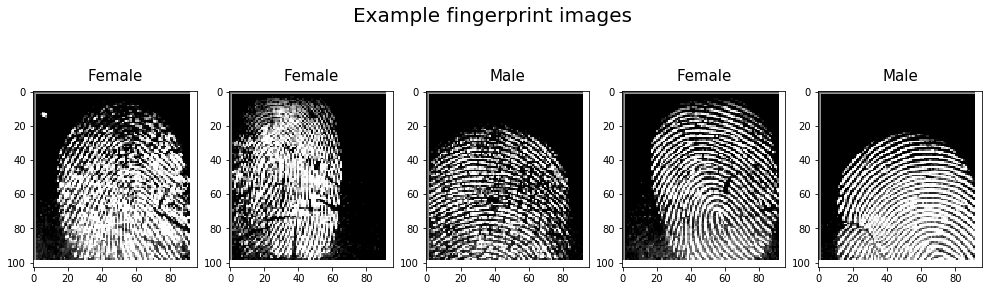

In [29]:
def plot_images(X, y, title='Example fingerprint images'):
    fig, axes = plt.subplots(1, len(X), figsize=(17, 5))
    
    for idx, ax in enumerate(axes):
        #ax.axis('off')
        ax.imshow(X[idx], cmap='gray_r')
        ax.set_title('Male' if y[idx] == 1 else 'Female', size=15, pad=10)
        
    fig.suptitle(title, fontsize=20)

random_sample = random.sample(range(1000), 5)
plot_images(X_gender_train[random_sample], y_gender_train[random_sample])

### MODEL

In [50]:
# Reshape the input arrays
X_gender_train = np.array(X_gender_train).reshape(-1, 103, 96, 1)
X_gender_val = np.array(X_gender_val).reshape(-1, 103, 96, 1)
X_gender_test = np.array(X_gender_test).reshape(-1, 103, 96, 1)

In [51]:
# Build some initial model
model = keras.Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), input_shape=(103,96,1), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(units=16, activation='relu'))
model.add(layers.Dense(units=8, activation='relu'))
model.add(layers.Dense(units=1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='accuracy', patience=5)


In [68]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 101, 94, 32)       320       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 50, 47, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 48, 45, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 24, 22, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 16896)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 16)                270352    
_________________________________________________________________
dense_11 (Dense)             (None, 8)                

In [52]:
history1 = model.fit(X_gender_train, y_gender_train, 
                    batch_size=128, 
                    epochs=30, 
                    verbose=1, 
                    #callbacks=[early_stopping], 
                    validation_data=(X_gender_val, y_gender_val))

Train on 1400 samples, validate on 600 samples
Epoch 1/30
1400/1400 [==============================] - 9s 6ms/step - loss: 14.1214 - accuracy: 0.5007 - val_loss: 0.7206 - val_accuracy: 0.5400
Epoch 2/30
1400/1400 [==============================] - 7s 5ms/step - loss: 0.6943 - accuracy: 0.5714 - val_loss: 0.7044 - val_accuracy: 0.5817
Epoch 3/30
1400/1400 [==============================] - 7s 5ms/step - loss: 0.6408 - accuracy: 0.6307 - val_loss: 0.7425 - val_accuracy: 0.5733
Epoch 4/30
1400/1400 [==============================] - 7s 5ms/step - loss: 0.6242 - accuracy: 0.6464 - val_loss: 0.8173 - val_accuracy: 0.5400
Epoch 5/30
1400/1400 [==============================] - 7s 5ms/step - loss: 0.5445 - accuracy: 0.7207 - val_loss: 1.1952 - val_accuracy: 0.5150
Epoch 6/30
1400/1400 [==============================] - 7s 5ms/step - loss: 0.7776 - accuracy: 0.6171 - val_loss: 0.6824 - val_accuracy: 0.5733
Epoch 7/30
1400/1400 [==============================] - 7s 5ms/step - loss: 0.5771 - acc

In [ ]:
def plotHistory(History):
    '''Generates two plots: (1) the train accuracy vs. validation accuracy and (2) train loss vs. validation loss.'''
    

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


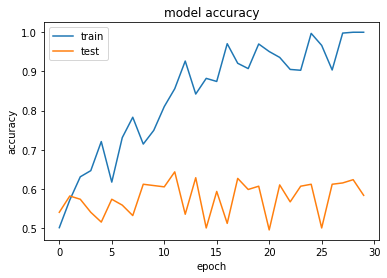

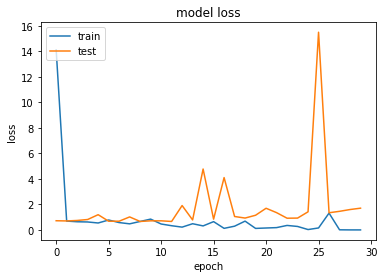

In [69]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [66]:
history.history

{'val_loss': [0.7205922404925028,
  0.7043940830230713,
  0.7425278457005818,
  0.8173397215207417,
  1.195203865369161,
  0.6823975173632304,
  0.6852521824836731,
  1.0200861597061157,
  0.6644371040662129,
  0.7136029545466105,
  0.7147048075993856,
  0.6645475474993388,
  1.9114756043752035,
  0.785109699567159,
  4.775626392364502,
  0.8449899458885193,
  4.10381690343221,
  1.0534172836939495,
  0.9309913158416748,
  1.151483469804128,
  1.6990480852127074,
  1.3556807645161946,
  0.9192087062199911,
  0.9283910250663757,
  1.4217355839411419,
  15.500218989054362,
  1.3475987768173219,
  1.4595058997472128,
  1.5993941243489582,
  1.7055856370925904],
 'val_accuracy': [0.5400000214576721,
  0.5816666483879089,
  0.5733333230018616,
  0.5400000214576721,
  0.5149999856948853,
  0.5733333230018616,
  0.5583333373069763,
  0.5316666960716248,
  0.6116666793823242,
  0.6083333492279053,
  0.6050000190734863,
  0.6433333158493042,
  0.5350000262260437,
  0.628333330154419,
  0.5,
  0

In [57]:
test_loss, test_acc = model.evaluate(X_gender_test, y_gender_test)

460/460 [==============================] - 1s 1ms/step


In [58]:
test_loss

0.5084048480119394

In [59]:
test_acc

0.876086950302124

In [63]:
len(X_gender_train)

1400

In [64]:
len(X_gender_val)

600

In [62]:
len(y_gender_test)

460